In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [66]:
## Read pickle data

df_train = pd.read_pickle("./df_train_norm_ts001.pkl")
df_test  = pd.read_pickle("./df_test_norm_ts001.pkl")

## For moving avg
#df_train = pd.read_pickle("./df_train_mvavg_norm_ts001.pkl")
#df_test  = pd.read_pickle("./df_test_mvavg_norm_ts001.pkl")

In [67]:
df_train

,unit,time,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32,RUL
0,0.0,0.000000,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.363986,0.333333,0.713178,0.724662,0.529086
1,0.0,0.002770,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.411312,0.333333,0.666667,0.731014,0.526316
2,0.0,0.005540,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.357445,0.166667,0.627907,0.621375,0.523546
3,0.0,0.008310,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.166603,0.333333,0.573643,0.662386,0.520776
4,0.0,0.011080,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.402078,0.416667,0.589147,0.704502,0.518006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,1.0,0.540166,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.656791,0.750000,0.271318,0.109500,0.011080
20627,1.0,0.542936,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.727203,0.583333,0.124031,0.366197,0.008310
20628,1.0,0.545706,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.922278,0.833333,0.232558,0.053991,0.005540
20629,1.0,0.548476,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.823394,0.583333,0.116279,0.234466,0.002770


# Modeling and Prediction
### Using SGD, RandomForest, SVM-SVR, XGBoost

In [68]:
mod = SGDRegressor()           #r2 score = -0.09
#mod = RandomForestRegressor()   #r2 score = -0.886
#mod = SVR(gamma='scale')         #r2 score = -1.0982420402692572
#mod = LinearRegression()          #-0.22042634578769915

In [69]:
mod.fit(df_train.iloc[:,2:15], df_train.iloc[:,15])
RUL_pred = mod.predict(df_test.iloc[:,2:15])

In [70]:
r2_score(df_test.iloc[:,15], RUL_pred)

-0.06365474765462298

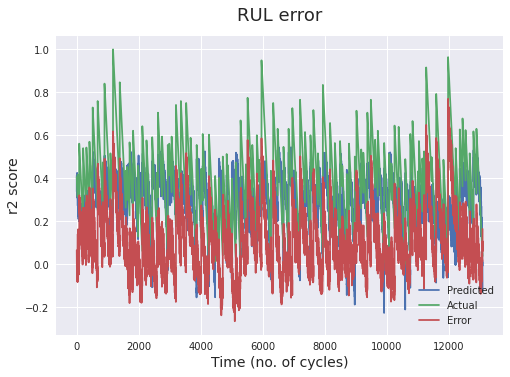

In [93]:
#plot actual vs predicted
plt.plot(RUL_pred, label = 'Predicted')
plt.plot(df_test.iloc[:,15], label = 'Actual')
plt.plot(df_test.iloc[:,15]-RUL_pred, label = 'Error')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Time (no. of cycles)', fontsize = 14)
plt.title('RUL error', fontsize = 18, y = 1.03)
plt.legend()

## Hyperparameter Tuning

In [78]:
#Select best model with optimal hyperparameters


model_params = {
#    'sgd': {
#        'model': SGDRegressor(),
#        'params' : {
#            "alpha": [0.001, 0.01, 0.1, 1, 10],
#            "penalty": ["none", "l1", "l2"]
#        }
#    },    
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators':[100, 150, 200, 300]    #[40, 60, 80, 100]
        }
    },
    'svm':{
        'model': SVR(gamma='auto'),
        'params':{
            'C':[30, 50, 70, 100],           #'C':[1, 10, 20],
            'kernel':['rbf']            #['rbf', 'linear']
        }
    },
    
}


In [79]:
scores = []

for model_name, mp in model_params.items():
    mod = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    mod.fit(np.asarray(df_test.iloc[:,2:15]), df_test.iloc[:,15])
    scores.append({
        'model':model_name,
        'best_score':mod.best_score_,
        'best_params':mod.best_params_
    })

model_params = {
    'sgd': {
        'model': SGDRegressor(),
        'params' : {
            "alpha": [0.001, 0.01, 0.1, 1, 10],
            "penalty": ["none", "l1", "l2"]
        }
    },    
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators':[40, 60, 80, 100]
        }
    },
    'svm':{
        'model': SVR(gamma='auto'),
        'params':{
            'C':[30, 50, 70],          
            'kernel':['rbf']            
        }
    },
    
}


scores:

[{'model': 'sgd',
  'best_score': 0.30072262955114154,
  'best_params': {'alpha': 0.01, 'penalty': 'none'}},
 {'model': 'random_forest',
  'best_score': 0.3351973906172864,
  'best_params': {'n_estimators': 100}},
 {'model': 'svm',
  'best_score': 0.3467897727626246,
  'best_params': {'C': 20, 'kernel': 'rbf'}}]
  
  [{'model': 'random_forest',
  'best_score': 0.3402758573970256,
  'best_params': {'n_estimators': 300}},
 {'model': 'svm',
  'best_score': 0.3469257868327697,
  'best_params': {'C': 70, 'kernel': 'rbf'}}]

In [80]:
scores

[{'model': 'random_forest',
  'best_score': 0.3402758573970256,
  'best_params': {'n_estimators': 300}},
 {'model': 'svm',
  'best_score': 0.3469257868327697,
  'best_params': {'C': 70, 'kernel': 'rbf'}}]

## Best  Model

### SVR, C=70, kernel = rbf


# Learning Curves with the best model

In [94]:
train_sizes=[1.0, 0.75, 0.5, 0.2, 0.1,0.01]
#train_sizes=[100000,20000,5000,1000]
svr = SVR(kernel='rbf', C=70)
train_sizes, train_scores, validation_scores = learning_curve(
estimator = svr,
train_sizes=train_sizes,
X = df_train.iloc[:,2:15],
y = df_train.iloc[:,15], cv = 3)

In [95]:
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1 )
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 137      0.659457
1375     0.851732
2750     0.835943
6877     0.743565
10315    0.738836
13754    0.684133
dtype: float64

 --------------------

Mean validation scores

 137      0.265070
1375     0.440823
2750     0.518477
6877     0.503978
10315    0.541469
13754    0.551721
dtype: float64


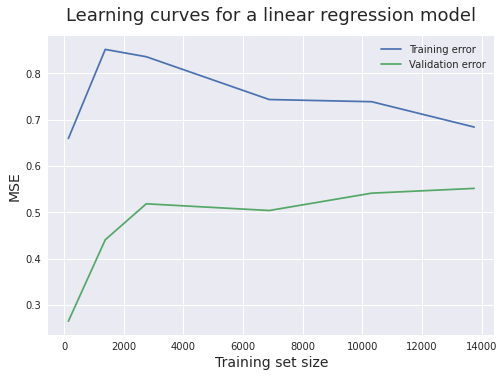

In [96]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
#plt.ylim(0,40)

### Conclusion: 
### WE need more training data as training error is still decreasing